In [52]:
import networkx as nx
import numpy as np
from networkx.algorithms import bipartite
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from src.helper import draw_spring, load_graph_from_json
np.random.seed(123)
import textdistance

import json


# 2 Network Properties and Plotting

This chapter will provide more detail about the structure of networks.

## 2.1 Paths, Shortest Paths, and Distance between Nodes

For any node of the network, it is possible to calculate the path it has to other nodes (if such a path exists) and its distance. A path is a series of steps getting from node A to node B. The distance is the number of steps, or the number of steps weighted by any relevant weight metric. 

Some complications deserve mention here:

* When nodes are disconnected
* Fully connected networks
* Shortest path
* Weighted paths
* Random paths
* Eccentricity and network diameter

Let us discuss the complications in more detail.


### A) When nodes are disconnected

It is not guaranteed that there will be a path between two nodes. It is possible that two sets of nodes are simply not connected. In this case there is no path between nodes A, B, or C, and nodes D or E, as we can see from this example:

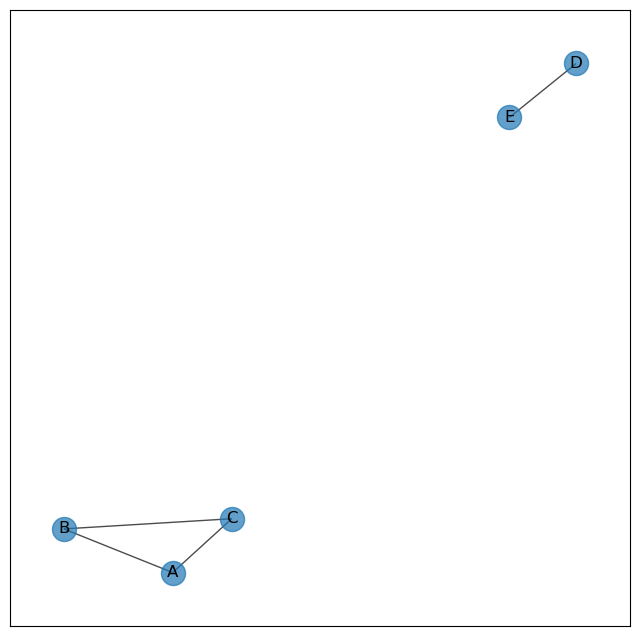

In [3]:
g_disconnected = nx.Graph()
g_disconnected.add_nodes_from(['A','B','C','D','E'])
g_disconnected.add_edges_from([('A','B'),('B','C'), ('C','A'),('D','E')])
draw_spring(g_disconnected)

### B) Fully connected networks

A network is fully connected if every node is connected to every other node. To see how this will look consider these graphs from Wolfram (https://mathworld.wolfram.com/CompleteGraph.html)

![image](images/ch2/wolfram.png)

A fully connected network will have a fixed number of edges as a function of how many nodes it has. That is, for every node $n$ a fully connected network will have $ \frac{n(n-1)}{2} $ edges. Note that for such networks it would be pointless to try to distinguish between nodes using measures like centrality or community, unless the edges have differing weights.

### C) Shortest paths

The shortest path is, quite simply, the path that will reach a node in the smallest number of steps. There can be more than one "shortest path" (but all the shortest paths will have the same smallest number of steps). For example, if we look at the kite graph, there are two shortest paths from 7 to 3, one going through 6, and another going through 5. There are longer paths too, for example, 7 -> 5 -> 2 -> 3. These may not be immediately relevant, but might be interesting possible random paths, between 7 and 3.

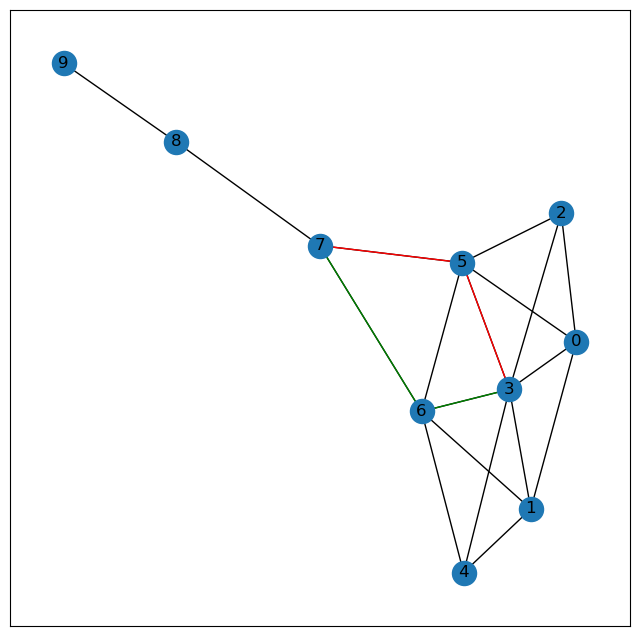

In [4]:
g_kite = nx.krackhardt_kite_graph()
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos)
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_edges(g_kite, edgelist=[(7,5),(5,3)], edge_color="red", pos=pos)
nx.draw_networkx_edges(g_kite, edgelist=[(7,6),(6,3)], edge_color="green", pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

While shortest paths can be easy to "see" in small graphs like this one, this will not be possible in more complex graphs. Finding the shortest path will then be a non-trivial problem. This process is automated by network analysis libraries and programs. 

Shortest paths are useful for many purposes. In the context of this presentation, it will be seen that they are key ingredients in many algorithms for identifying the most important or most central nodes of a network.

For the unweighted graphs that we are using, a shortest path counts discrete "steps" between nodes. This implies that all the nodes are a unit distance away. However, it is also possible to have weighted paths, as we will see in a bit. 

### D) Random paths

The length of the shortest path will be a definite number. However, there may be a large or arbitrary number of non-shortest paths wandering through the nodes. 

#### note this might not be true if we rule out cycles

A single arbitrary path will not be of much interest (why this one?, why not another one?), but if we allow movement randomly from node to node, these random paths - random walks - can become useful. We may be interested not only in the shortest path between A and B, but in the average path distance between A and B, taking into account routes that go more or less directly from A to B, as well as those that make longer detours. By measuring a number of random walks for a number of nodes in the network, it will often become clear that some nodes are more likely to be "passed through" than other nodes, which suggests these nodes are more central and perhaps therefore more relevant or interesting.

NetworkX does not have a function to generate a single random path starting from a given node. However one can make one with the neighbors attribute of the Graph object. The steps are more or less like this:

1. Select a number of steps for the walk. In this case four steps. Do all the steps below until you hit four steps.
2. Select a particular node to start with, for example node 7.
3. Find all the neighbors of node 7 (in this case, 5, 6, 8).
4. Randomly choose one of these nodes to go to. Say choose node 5.
5. Update the value of your start position to the chosen node, in this case 5.
6. Record that you have made one step (3 to go).
7. If you have made less than four steps, go back to step 2. If you have made four steps, stop.

These steps can be implemented in code as follows:

In [15]:
# here we are limiting the number of steps to 4, we get 5 steps in the answer because the answer includes the start node, and n is initialized at 0.

n = 0
start = 7
history = [start]
while n < 4:
  my_neighbors = list(g_kite.neighbors(start))
  move_to_node = np.random.choice(my_neighbors)
  history.append(move_to_node.tolist())
  start = move_to_node
  n += 1

print(history)

[7, 8, 9, 8, 7]


Most likely we will not be interest in a single random path, but in lots of them, and they can be generated "in bulk" using the ```generate_random_paths``` function.

In [8]:
random_paths = nx.generate_random_paths(g_kite, sample_size=10, path_length=4)
for i in random_paths:
    print(i)

[0, 3, 2, 0, 2]
[4, 3, 2, 0, 3]
[8, 7, 6, 5, 2]
[6, 3, 2, 0, 2]
[8, 9, 8, 7, 5]
[6, 4, 1, 3, 6]
[4, 3, 4, 1, 3]
[4, 6, 7, 5, 3]
[7, 6, 5, 0, 5]
[1, 3, 2, 0, 2]


### E) Weighted edges


An edge can show that there is a relationship between nodes A and B. The nature of that relationship can be many things, such as there being a train between A and B, or that case A cites case B. In these instances the relationship is binary: there either is a connection or there is not.

However there is a range of cases where one wants to record the strength of a connection and not just its presence. For example, one might want to record, not only that there is train path from A to B, but also how long that path is in terms of kilometers. We might want to score not only that case A cites case B, but also how many times case B is cited by case A. We can add this attribute to the edge by giving weights to edges. For instance, if case A cites case B four times, the edge weight becomes four.

Weighted networks can be represented visually in an intuitive way by using different colors or line styles for their edges. Below is a network using a document similarity matrix. This matrix records how close two documents are in light of the tokens they share (Jaccard distance) and scores them with 1 if they are identical, and 0 if they are completely different. It is made of a set of ECHR Grand Chamber judgments on the extraterritorial application of fundamental rights. 


In the process of comparing the distance between each document, this dataframe is turned into a matrix, and that can be used to build a network. Please see Appendix 1: "Text Similarity Networks" for more details of how this can be done. Here is one way to plot that network keeping only the edges between cases that have more that score higher than average similarity:

In [77]:
np.mean([z for x,y,z in g_distances.edges.data("weight")])

np.float64(0.5263527436501125)

In [ ]:
np.mean([e for e in g_distances.edges.

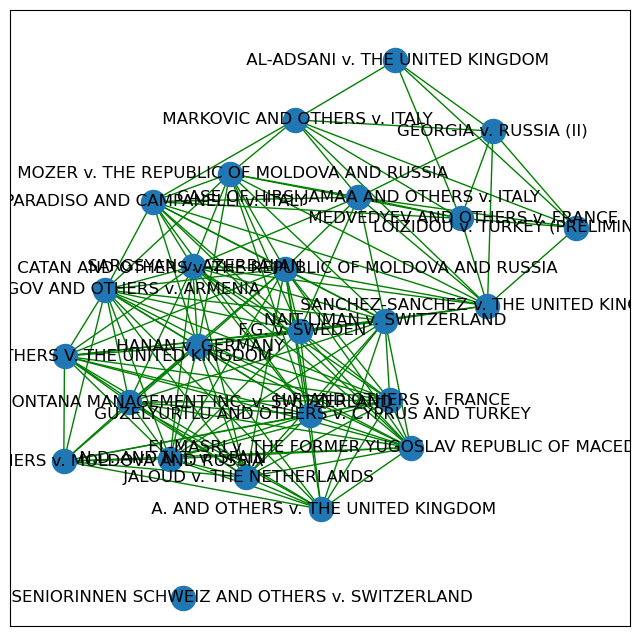

In [78]:
g_distances = load_graph_from_json("data/g_distances.json")
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_distances, seed=123)
nx.draw_networkx_nodes(g_distances, pos)
lowweight = [e for e in g_distances.edges if g_distances.edges[e]['weight'] < 0.53]
highweight = [e for e in g_distances.edges if g_distances.edges[e]['weight'] > 0.53]
nx.draw_networkx_edges(g_distances, edgelist=highweight, pos=pos, edge_color='green')
#nx.draw_networkx_edges(g_distances, edgelist=lowweight, alpha=0.4, pos=pos, edge_color='red')
nx.draw_networkx_labels(g_distances, pos=pos);

For our purposes, what is to note is that if you graph the network without consideration of weight, it gives you a fully connected network, which is a nice geometrical figure, but not very informative. Every document was compared to every other document, so every node is on step ("one degree") of separation from every other and so every node has the exact same number of neighbors.

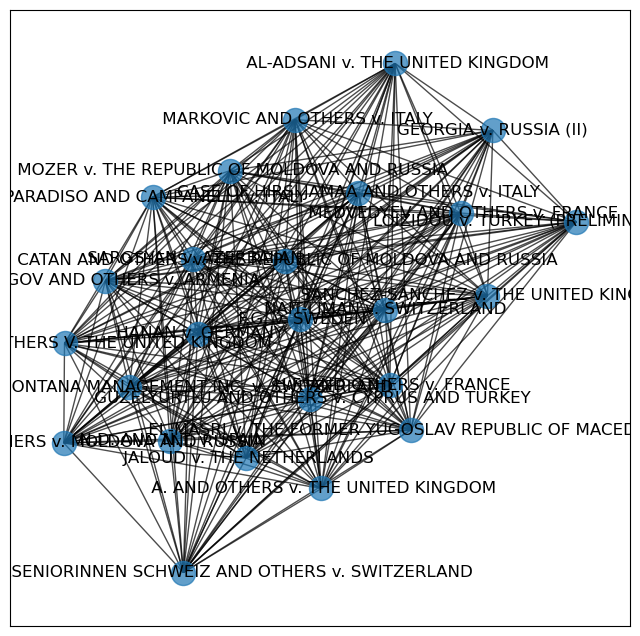

In [74]:
draw_spring(g_distances)

A bar plot can further reveal how uninformative this is:

<BarContainer object of 25 artists>

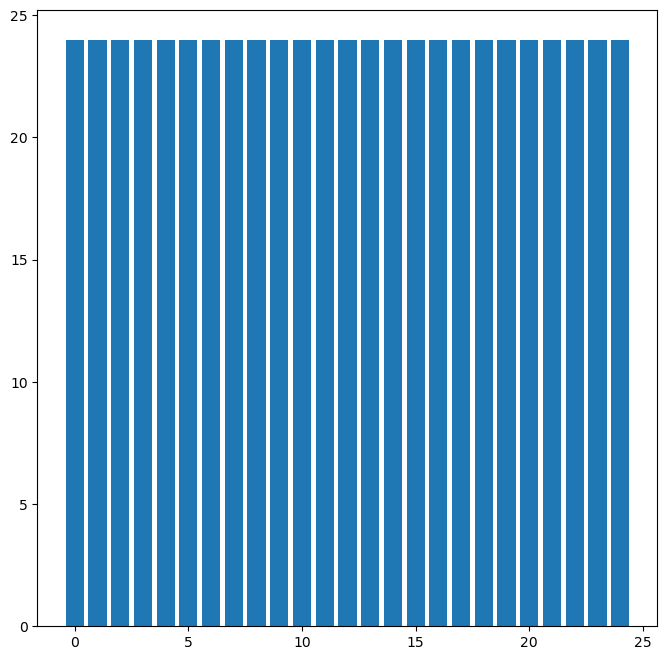

In [89]:
plt.figure(figsize=(8,8))
plt.bar(x = [x for x in range(len(list(dict(g_distances.degree).keys())))], height = list(dict(g_distances.degree).values()))

It is a bit hard to see, but note that this is a fully connected or complete graph. NetworkX can reveal this to us by simply passing the graph to the function 
```python
nx.is_connected()
```

In [83]:
nx.is_connected(g_distances)

True

However things change if weights are added.

<BarContainer object of 25 artists>

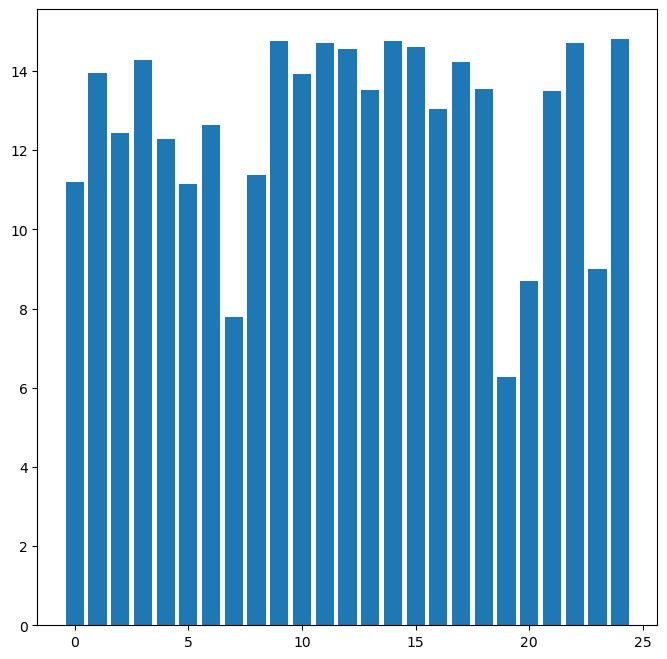

In [90]:
plt.figure(figsize=(8,8))
plt.bar(x = [x for x in range(len(list(dict(g_distances.degree).keys())))], 
                 height = list(dict(g_distances.degree(weight="weight")).values()))

If the network is not too dense, weights can be drawn into the plot to make it more informative. This cannot really be done with the ECHR judgments, but with a smaller dataset of book reviews it is possible:

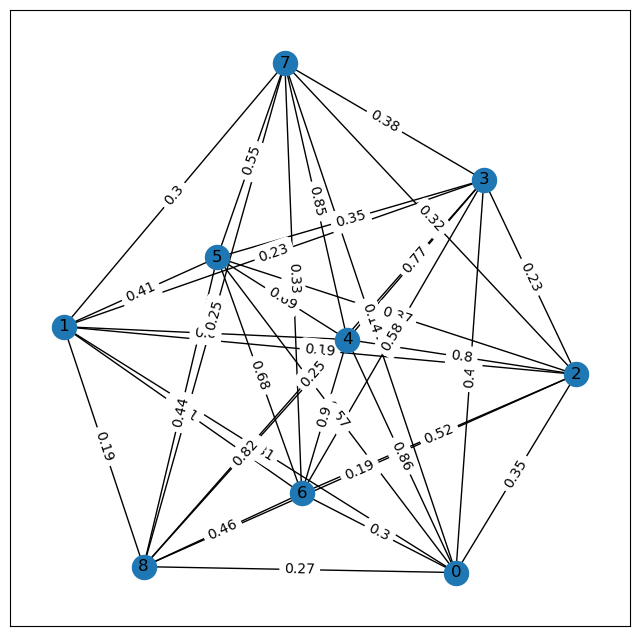

In [86]:
g_docs = load_graph_from_json("data/g_docs.json")
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_docs, seed=123)
nx.draw_networkx_nodes(g_docs, pos)
nx.draw_networkx_edges(g_docs, pos=pos)
labels = {e: np.round(g_docs.edges[e]['weight'],2) for e in g_docs.edges}
nx.draw_networkx_edge_labels(g_docs, pos, edge_labels=labels)
nx.draw_networkx_labels(g_docs, pos=pos);

In the past we stated that assessing centrality or community of fully connected networks can be pointless, for all the nodes are then by definition connected to all the other nodes, and so they will get identical scores. However in this case it is not pointless to assess the centrality or community of its nodes, because the edges have different weights. This is illustrated in the section on closeness centrality below.

Calculating shortest paths is different for weighted edges than for unweighted edges. In unweighted graphs it would be a matter of counting the steps on different paths and finding the one with the lowest number of steps, whereas in weighted graphs the procedure is to count the steps and multiply every step by its weight.

Also note that the weight can represent closeness or distance. If it represents distance, then one must simply multiply by it. If it represents closeness, we need to convert it into distance by using its reciprocal.

$$ distance = \frac{1}{closeness} $$ 

### F) Network Density

Lets remember the fully connected networks discussed earlier

![image](images/ch2/wolfram.png)

Since every node here will be connected to every other node (there are no strangers, everyone is a neighbor of everyone else, everyone has maximum popularity) it can be said that these networks are maximally dense.

A maximally dense network will have $ \frac{n(n-1)}{2} $ edges.

So a network with 3 nodes can have a maximum of 3 edges, an network with 4 nodes 6 edges, a network with 5 nodes 10 edges, and so forth.

The network density will be the ratio of the number of edges actually present $ m $ to the hypothetical maximum, in other words:

$$ \frac{m}{n(n-1)/2} $$

### G) Eccentricity and Network Diameter

Next we need to consider eccentricity. Eccentricity records the longest shortest path between
every node. In the kite graph above, we can see that the eccentricity of node 9 is 4, as the maximum shortest path that exist between that node and some other node is four steps. Node 7, by contrast, has a maximum eccentricity of 2, as the longest shortest path that exist between it any other node is just 2.

Just as we can be interested in what is the center of a network, we can be interested in how large the network is. However, one cannot just "eye" a network graph to get a sense of its dimensions, because a graph can be plotted in many different ways and still be the same network.

The diameter of a network is very simple to calculate. It is just the maximum eccentricity value. A network is as wide as the longest shortest path that it includes. For the kite network, no node is further away than four steps from any other (that is the longest shortest path), and thus that is its diameter.

In [55]:
nx.diameter(g_kite)

4

## 2.2. Subgraphs

A graph can be broken down into subgraphs, which have the same (trivially) or less nodes than the original graph. This can be done by specifying the nodes you want to select. Here, for example, we  take the "tail" out of the kite, by not including nodes 7, 8, and 9 in the subgraph.

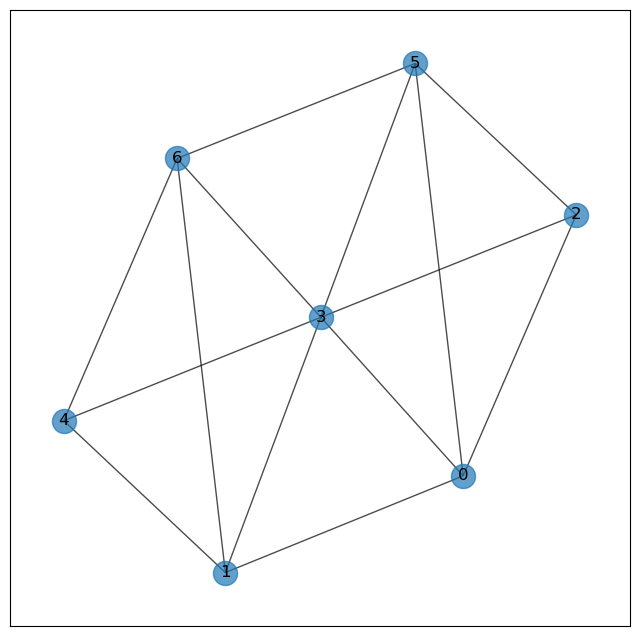

In [56]:
g_subkite = g_kite.subgraph([0,1,2,3,4,5,6])
draw_spring(g_subkite)

The kitegraph is a rather small graph and intuitive to interpret when visualized. The CJEU case law network is a larger one that is uninterpretable when all nodes are visualized.

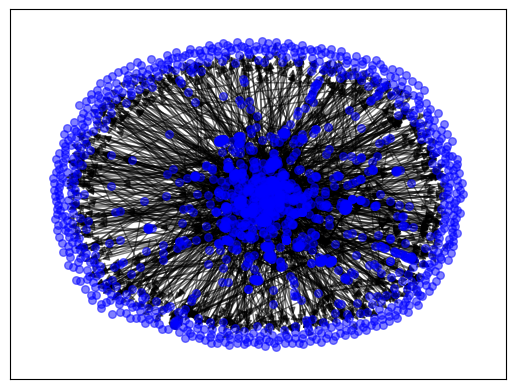

In [57]:
g_consprot = load_graph_from_json("data/g_consprot.json")
pos = nx.spring_layout(g_consprot)
nx.draw_networkx_nodes(g_consprot, pos=pos, node_color="blue", node_size=30, alpha=0.5)
nx.draw_networkx_edges(g_consprot, pos=pos, edge_color="black", alpha=0.5);

One (!) way of making the network more comprehensible, is to create a sub-network. Here, we create and plot a sub-network of cases that have a degree score of at least 25, meaning that they have 25 or more citations (counting both incoming and outgoing citations). The network becomes much smaller now.

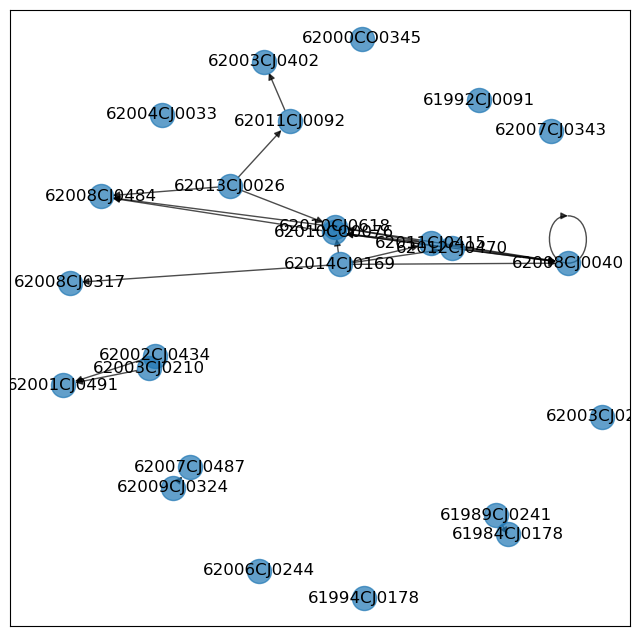

In [58]:
node_degree_dict=nx.degree(g_consprot)
g_consprot2=nx.subgraph(g_consprot,[x for x in g_consprot.nodes() if node_degree_dict[x]>=25])
# note: this code has already been run in the prerequsites section, but we are running it again here to exemplify the process of
# making a subgraph
draw_spring(g_consprot2)


Some nodes are disconnected from the other nodes. This may seem surprising given the fact that the subgraph includes the "best connected" nodes). This occurs because the subgraph function completely removes the unselected nodes. When such nodes are removed, it is to be expected that the degree values of the nodes in the sub-network also decreases. If some nodes were only connected to unselected nodes they will now appear alone having a degree of 0 in the subgraph.

## 2.3 Ego Networks

One important type of subgraph is the ego netowrk, which is centered on one particular node ("the ego" or self) and then contains only those nodes that have a path to the ego within a given radius. That is to say, we can see only the nodes that are a defined number of steps away from the "ego".

This can be useful to zoom in on one particular set of relations. For example, using the karate club graph we can use ego networks to see all the nodes that are one step away from the karate instructor (node 33 in the networkx version of the dataset).


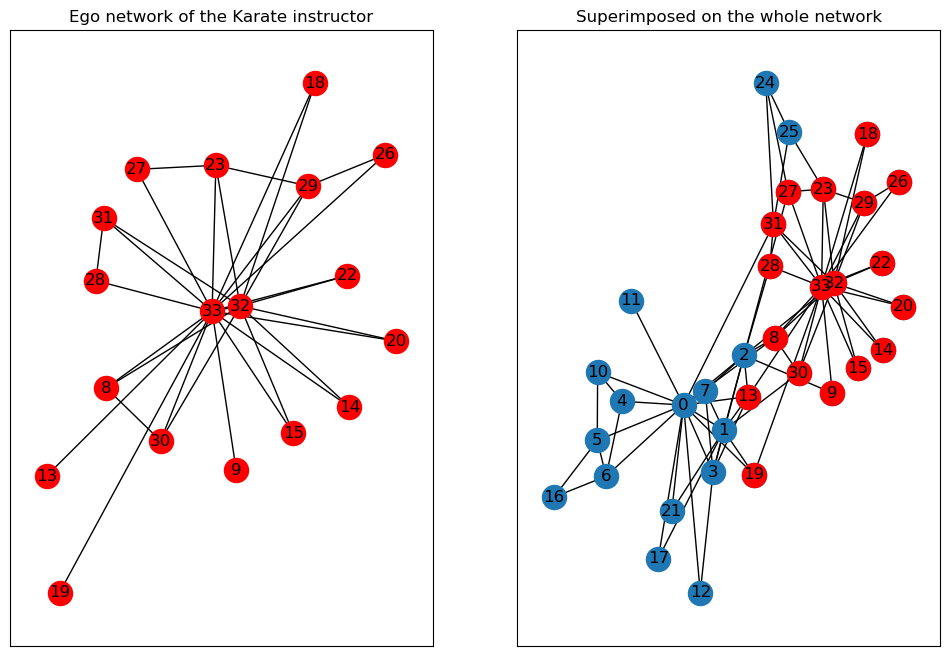

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
g_karate = nx.karate_club_graph()
ego_karate = nx.ego_graph(g_karate, 33)
pos = nx.spring_layout(g_karate, seed=123)
nx.draw_networkx_nodes(ego_karate, pos=pos, ax=ax[0], node_color="red")
nx.draw_networkx_labels(ego_karate, pos=pos, ax=ax[0])
nx.draw_networkx_edges(ego_karate, pos=pos, ax=ax[0])
nx.draw_networkx_nodes(g_karate, pos=pos, ax=ax[1])
nx.draw_networkx_nodes(ego_karate, pos=pos, node_color="red", ax=ax[1])
nx.draw_networkx_labels(g_karate, pos=pos, ax=ax[1])
nx.draw_networkx_edges(g_karate, pos=pos, ax=ax[1])
ax[0].set_title("Ego network of the Karate instructor")
ax[1].set_title("Superimposed on the whole network");


## 2.4 Flattening Bipartite Networks

A bipartite network has two types of nodes. One such example already introduced is states (node type 1) and treaties that they have ratified (node type 2).

Because of its bipartite form, such network cannot be directly analyzed using conventional methods such as centrality, edges to treaties and to countries are treated the same. One solution is to project the network into a single level, that is, to flatten it. 

Flattening involves removing the upper level nodes (treaties). Instead one creates connections between the lower level nodes (countries), weighted by how many upper level nodes they shared before.

In [60]:
g_treaties = load_graph_from_json("data/g_treaties.json")
states = [x[0] for x in list(g_treaties.nodes(data="bipartite")) if x[1] == 0]
treaties = [x[0] for x in list(g_treaties.nodes(data="bipartite")) if x[1] == 1]
g_treaties_flat = nx.bipartite.weighted_projected_graph(g_treaties, nodes=states)


Text(0.5, 1.0, 'Flattened Bipartite Network')

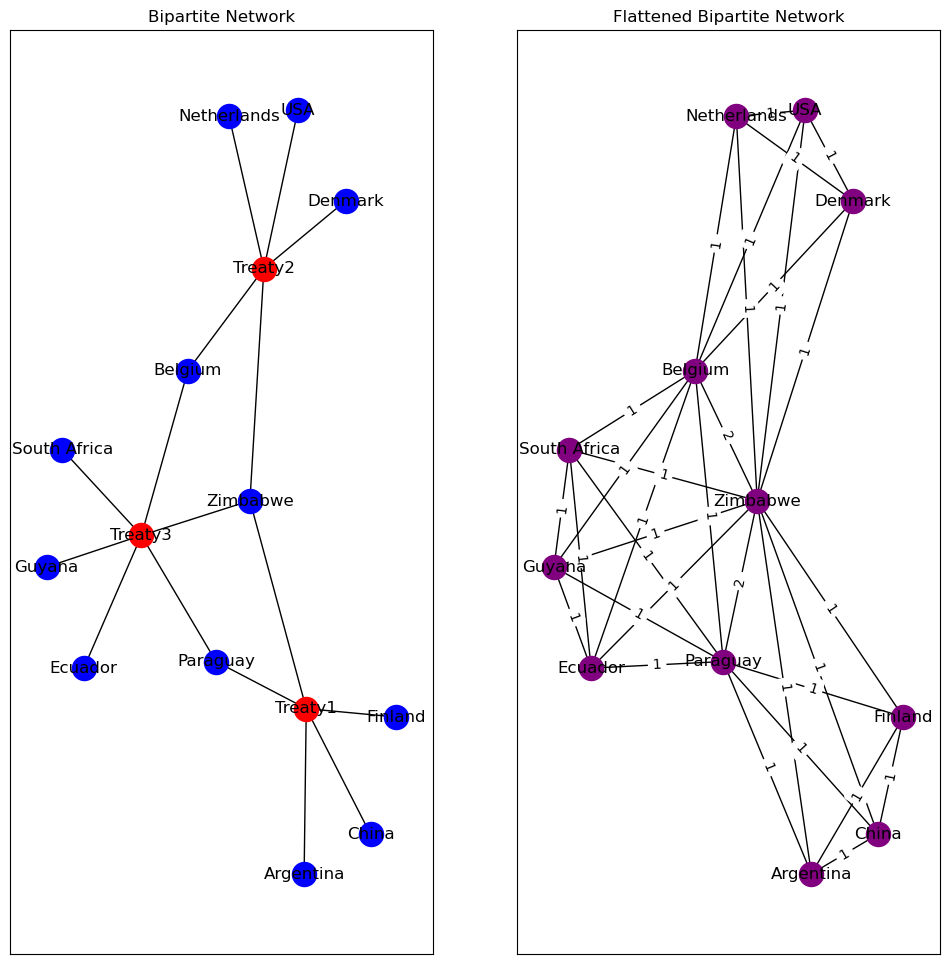

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,12))

pos = nx.spring_layout(g_treaties, seed=123)
nx.draw_networkx_nodes(g_treaties, pos=pos, nodelist= states, node_color='blue', ax=ax[0])
nx.draw_networkx_nodes(g_treaties, pos=pos, nodelist= treaties, node_color='red', ax=ax[0])
nx.draw_networkx_edges(g_treaties, pos=pos, ax=ax[0])
nx.draw_networkx_labels(g_treaties, pos=pos, ax=ax[0]);

edgelabels = {(e,w):list(g_treaties_flat.get_edge_data(e,w).values())[0] for e,w in g_treaties_flat.edges}
pos = nx.spring_layout(g_treaties, seed =123)
nx.draw_networkx_nodes(g_treaties_flat, pos=pos, node_color="purple", ax=ax[1])
nx.draw_networkx_edges(g_treaties_flat, pos=pos, ax=ax[1])
nx.draw_networkx_labels(g_treaties_flat, pos=pos, ax=ax[1]);
nx.draw_networkx_edge_labels(g_treaties_flat, pos, edge_labels=edgelabels, ax=ax[1]);
ax[0].set_title("Bipartite Network")
ax[1].set_title("Flattened Bipartite Network")

Unlike the previous networks that we used, which were easy to survey with the naked eye, this one already presents difficulties. For instance, it is difficult to determine whether this network is fully connected. A computation shows this is the case. The need to rely on computation instead of visualization will only increase as one starts to work with larger networks.

In [62]:
nx.is_connected(g_treaties_flat)

True

## 2.5 Network Metadata

Networks can store more than just connections between nodes and edges. The nodes and the edges can have attributes. We have already encountered one of such attributes, which is the "weight" attribute on an edge. Accessing such information we can query the network and visualize sub-networks that meet specific criteria. 

Lets first query edge weights using the document network that already has weights.

In [63]:
list(g_docs.edges(data="weight"))

[(0, 1, 0.3057850860342909),
 (0, 2, 0.3515643806261561),
 (0, 3, 0.4011441744419861),
 (0, 4, 0.8588650335933432),
 (0, 5, 0.5663867925847853),
 (0, 6, 0.3036944274298017),
 (0, 7, 0.1427956434168483),
 (0, 8, 0.2663586423650602),
 (1, 2, 0.1887291756697731),
 (1, 3, 0.2301873550390033),
 (1, 4, 0.800124882934437),
 (1, 5, 0.4122354734424759),
 (1, 6, 0.5097321851655097),
 (1, 7, 0.3027866619120244),
 (1, 8, 0.1868838597034725),
 (2, 3, 0.2280158058874547),
 (2, 4, 0.7995610591992457),
 (2, 5, 0.366590703499365),
 (2, 6, 0.5195230803085847),
 (2, 7, 0.317271203011655),
 (2, 8, 0.1896235506799158),
 (3, 4, 0.7678964587257362),
 (3, 5, 0.3480240462634174),
 (3, 6, 0.5762447937744228),
 (3, 7, 0.3808681395940203),
 (3, 8, 0.2481169176073587),
 (4, 5, 0.6878902741436519),
 (4, 6, 0.9008941138337112),
 (4, 7, 0.8540864919561113),
 (4, 8, 0.8214267919513534),
 (5, 6, 0.6824646015295808),
 (5, 7, 0.5453013285723745),
 (5, 8, 0.4356888455303136),
 (6, 7, 0.3289244386028924),
 (6, 8, 0.4649224

We can then filter out the edges that satisfy a certain edge condition.

For example here we will isolate the nodes that have an edge with a weight of more than 0.8 and see them as a subgraph or draw them as part of a graph with a different color.

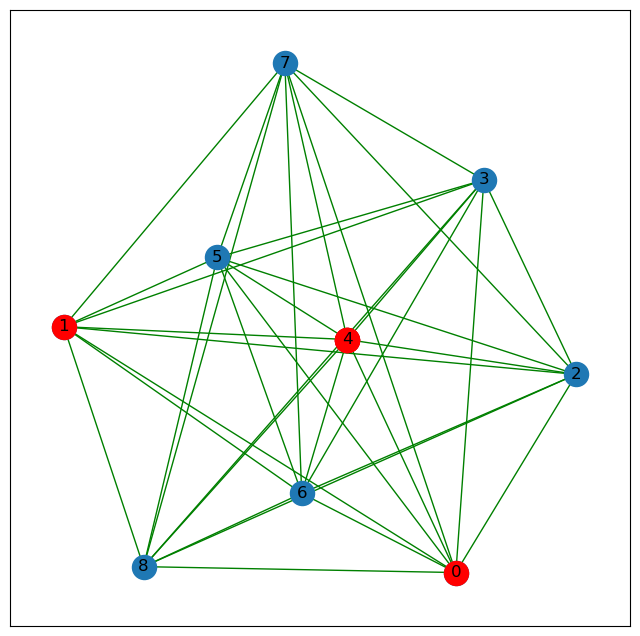

In [64]:
mynodelist = [node for node, edge, weight in g_docs.edges(data="weight") if weight > 0.8]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))

pos = nx.spring_layout(g_docs, seed=123)
nx.draw_networkx_nodes(g_docs, pos)
nx.draw_networkx_nodes(g_docs, nodelist=mynodelist, pos=pos, node_color="red")
nx.draw_networkx_edges(g_docs, pos=pos, edge_color='green')
nx.draw_networkx_labels(g_docs, pos=pos);

## 2.6 Meta-data other than weights

In fact NetworkX can include arbitrary metadata, not just edge weights. The best way to encode such information is directly in the file format that generates the network. For this the most ideal approach might be JSON, as this puts very little limits on what you can add as additional information and be edited manually or through code. In this example we can see that some nodes in the legal history network have a  "type" designator in addition to the normal node id and edge information. For more detail on JSON see appendix 1.

In [65]:
g_lh = load_graph_from_json("data/g_lh.json")

In [66]:
resdict = dict(g_lh.nodes(data="type"))
pd.DataFrame({'nodes':resdict.keys(), "values":resdict.values()})

,nodes,values
0,R16545,Case law
1,R16556,Case law
2,C10099,Basic source
3,C10415,Basic source
4,C10705,Basic source
5,RRC4123,Roman law
6,RLMech777,Customary law
7,RLMech7781,Customary law
8,RLMech7782,Customary law
9,RLZutph1,Customary law


The type of plot you see below was not done with ```networkx``` but with `[Gephi](https://gephi.org). Gephi is a graphical user interface network analysis and visualization software. While it is less powerful than ```networkx``` as a tool for analysis, it truly excels in making attractive visualizations. Gephi receives further discussion in Chapter 6. 

![image](images/ch2/legal_history.jpg)


The support of an arbitrary range of metadata is an advantage of working with networkx. With some data wrangling, metadata and network metrics can be put side-by-side in a DataFrame format.

In [67]:
res = nx.degree_centrality(g_lh)
type = [x[1] for x in g_lh.nodes(data="type")]
resdf = pd.DataFrame({"nodes":res.keys(), "centrality":res.values(), "type":type})
resdf

,nodes,centrality,type
0,R16545,0.034483,Case law
1,R16556,0.068966,Case law
2,C10099,0.827586,Basic source
3,C10415,0.482759,Basic source
4,C10705,0.137931,Basic source
5,RRC4123,0.068966,Roman law
6,RLMech777,0.068966,Customary law
7,RLMech7781,0.034483,Customary law
8,RLMech7782,0.034483,Customary law
9,RLZutph1,0.034483,Customary law


Now we can use DataFrame analytics like groupby on network metadata, as can be seen below.

In [68]:
grouped = resdf.groupby("type")['centrality'].mean()
grouped

type
Basic source     0.482759
Case law         0.051724
Customary law    0.055172
Roman law        0.043678
Name: centrality, dtype: float64

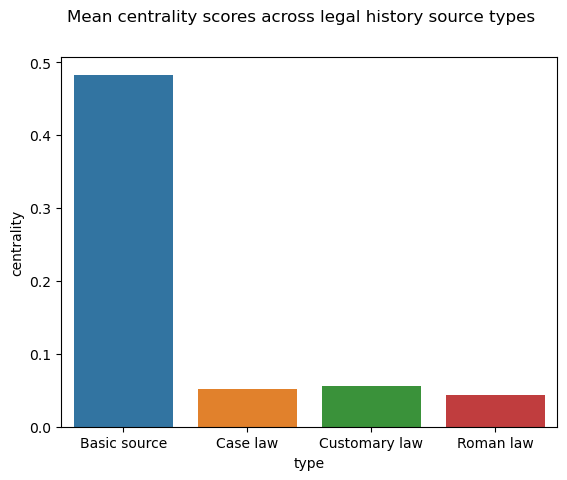

In [69]:
sns.barplot(x = grouped.index, y = grouped)
plt.suptitle("Mean centrality scores across legal history source types");

### Positional encodings

With some further work we can get "positional encodings" such as node embeddings and put them side-by-side. The encodings here are obtained from pytorch's geometric module. This is a nerual network library that has a module for dealing with graph information. Introducing neural networks and pytorch is outside the scope of this textbook. However they are mentioned here to make a general point that underscores the value of network models: networks are in the end another source of information, that can be put in a DataFrame format, and enriched with traditional forms of information. Then they can be used for inference with virtually any machine learning or statistical model. 



In [70]:
pygraph = from_networkx(g_lh)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(
    pygraph.edge_index,
    embedding_dim=3,
    walks_per_node=100,
    walk_length=3,
    context_size=2,
    p=0.5,
    q=1.0,
    num_negative_samples=1,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

loader = model.loader(batch_size=3, shuffle=True, num_workers=4)

pos_rw, neg_rw = next(iter(loader))

def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [71]:
train()
z = model()
X = z.detach().numpy()

After running pytorch here we put the embeddings side-by-side with our DataFrame. As noted, what you see below is meant simply to illustrate how a network can be reduced to positional embeddings and then these can be used alongside traditional network metrics ("centrality") and other data that is in columnar format ("type"). No effort has been made to ensure that the embeddings are actually optimal. Using neural networks may require a lot of find tuning in parameters such as batch size and learning rate, that are not our concern here.

In [72]:
encodings = pd.DataFrame(X, columns=['encoding_0', 'encoding_1', 'encoding_2'])

In [73]:
resdf = pd.concat([resdf, encodings], axis=1)
resdf

,nodes,centrality,type,encoding_0,encoding_1,encoding_2
0,R16545,0.034483,Case law,-0.277071,1.170594,0.070576
1,R16556,0.068966,Case law,-0.539401,-0.957019,1.007164
2,C10099,0.827586,Basic source,0.379876,0.633959,-0.332181
3,C10415,0.482759,Basic source,0.250362,-0.014567,-1.174677
4,C10705,0.137931,Basic source,0.055535,1.792582,-0.813831
5,RRC4123,0.068966,Roman law,0.813118,0.569943,0.618256
6,RLMech777,0.068966,Customary law,-0.223451,-0.463917,0.577744
7,RLMech7781,0.034483,Customary law,0.428249,-0.601519,0.980935
8,RLMech7782,0.034483,Customary law,-1.687270,-0.051577,-1.189124
9,RLZutph1,0.034483,Customary law,0.506953,-1.315531,0.416696


Now we will use this expanded matrix to make a decision tree that predicts what legal source type we have. The data is highly non-linear, so regression models will not perform well, but trees might. We will not evaluate the tree, because the point is simply to show how the expanded dataframe can be used together with other machine learning tools outside network analysis. Through embeddings the methodology of network analysis connects to the mainland.

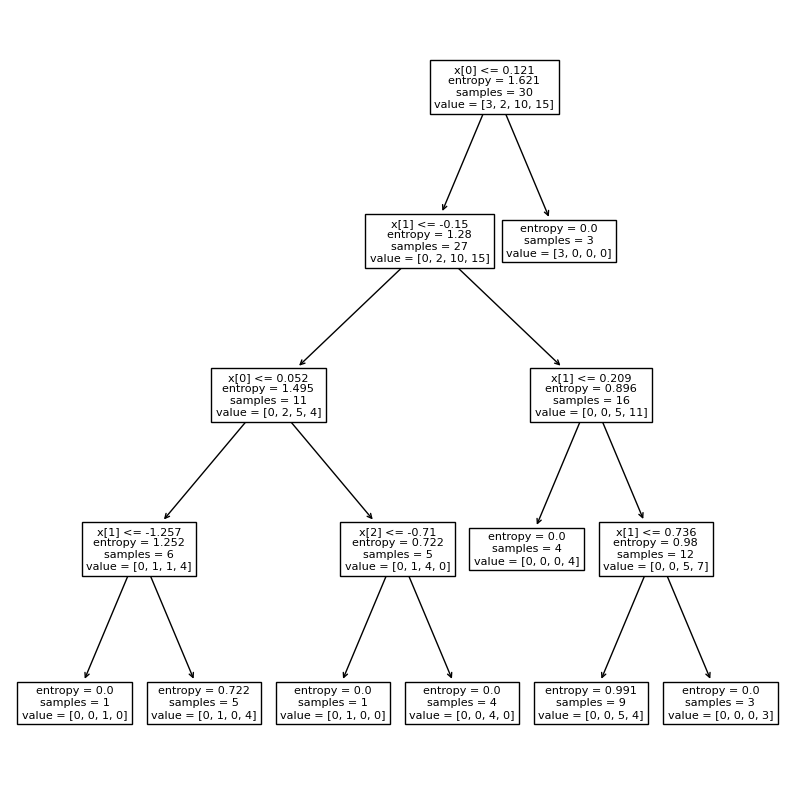

In [84]:
X = resdf.drop(['nodes', 'type'], axis=1)
y = resdf.type

tree = DecisionTreeClassifier(criterion="entropy", max_depth=4, random_state=123).fit(X,y)


plt.figure(figsize=(10,10))
plot_tree(tree);

## 2.7 Plotting


Plotting can be very relevant, or not so relevant, depending on the research task at hand. In small networks plotting can create powerful insights. The human mind can very rapidly grasp intuitive properties of a network by just looking at it, without making any calculation. However, it is often the case that large networks plotting leads to "hairballs" where nothing of interesting can be discerned. 

High level plotting skills can -to a large extent- overcome this "hairball" problem, however such techniques are outside the scope of this work. At some point plotting becomes a skill in itself, and gets handed over to specialists, who are possibly not the same persons who are using network analysis to provide insight into the legal research questions. This book respects such division of labor, and thus presentation of plotting will remain basic. THat being said we will introduce *some* simple techniques that can help us tame hairballs somewhat. 

It perhaps should be noted that networkx does not excel as a plotting package. There are better options, and Gephi (discussed on Chapter 6) is more powerful, and takes a different approach altogether (it is not a tool based on coding, but on a graphical user interface). It is alwo work noting that networkx builds its plotting abilities on top of matplotlib, a widely used plotting library for python, that is more geared towards satisfying the needs of scientists than for making beautiful visualizations. Those looking for the latter need to look elsewhere.

Lets start with a small plot that provides immediate insight into the netowkrk. Lets use a classic built in graph, the barbell graph. This looks precisely like the weight lifting instrument that bears the same name. Two heavy weights connected by a metal shaft. Just by visualizing it we can guess which node plays an important brokerage role in the network, such that if removed the network would be disconnected. We can also see that there are two clear communities. The two ends of the barbell. The barbell graph is not too far away from two kite graphs with the tails joined together.

Note that in the function below (the graph constructor) network is allows us to define how many nodes will be present in the "plates" of the barbell, and how many nodes will make up the staff. Here we have made some conservative choices.

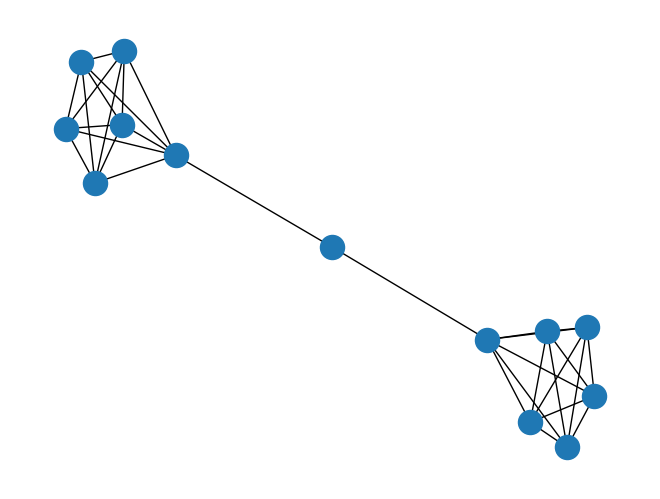

In [136]:
g_barbell = nx.barbell_graph(6, 1)
nx.draw(g_barbell)

Here we have used the ````nx.draw()```` function to "automatically" create a graph for us. This function however is a "default" drawing function and it is fine for viewing simple graphs like this. In order to customize the graph we need to take another more step-by-step approach. Note that this default graph does not provide some information we may want to see (at least in small graphs) like node labels. It is also the case that the "layout" of the nodes is randomized, so every time we draw the barbell, we will get different results. see below:

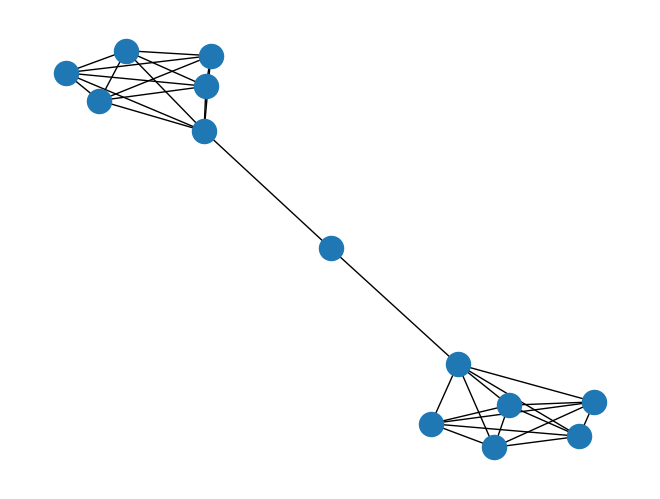

In [137]:
nx.draw(g_barbell)



Before entering into that, lets have a look at the "hairball" phenomenon. Here we are going to look at the consumer protection cases data. As you can see, the default drawing function provides no insight whatsoever.

Now 

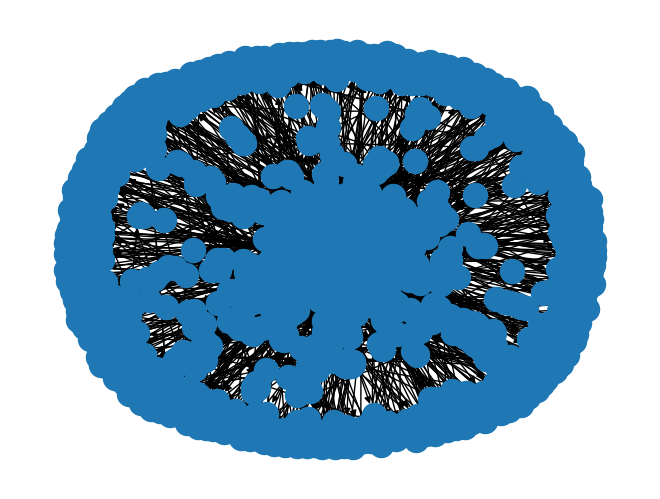

In [138]:
g_consprot = load_graph_from_json("data/g_consprot.json")
nx.draw(g_consprot)

The consumer protection database has only 1614 nodes, and while this may be big compared to the kite or the barbell graph we just introduced, it is actually quite small, for the number of cases that modern data-enabled research is bound to consider.

## Custom plotting

To start looking a custom plotting perhaps it is best to start with the ```draw_spring``` function that we have saved in our "helper" library, and which we have used to render some drawing throughout this repository. Here we are going to take the barbell, make it green, and plot it in a smaller window. We will also introduce a local seed to ensure that every time we draw this plot, the shape stays the same (that is, we always get the same random result). Unlike the default plotting function ```draw_spring``` will also provide node labels. Instead of calling the ````draw_spring```` function from our helper library, we will just copy-paste it here, so it is part of this notebook's code. 

In [139]:
def draw_spring(graph, seed=123, node_color="blue", figsize=(8,8)):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(figsize))
    pos = nx.spring_layout(graph, seed = seed)
    nx.draw_networkx_nodes(graph, pos=pos, node_color=node_color, ax=ax)
    nx.draw_networkx_edges(graph, pos=pos, ax=ax)
    nx.draw_networkx_labels(graph, pos=pos, ax=ax);



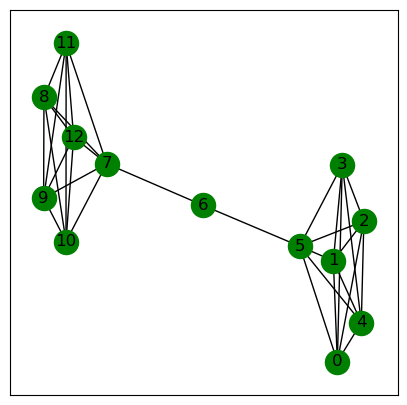

In [140]:
draw_spring(g_barbell, node_color="green", figsize=(5,5))

Having seen the result, lets unpack what the function is doing. Instead of just asking NetworkX to draw the graph all at once, it works in layers. We get to make decision on the layout, on the nodes, the edges and the labels step-by-step, and other layers could be added. By being bundled in a function, these steps happen all at once, here we will unpack them as much as possible (the bare minimum of a working graph will have a layout layer and an edges layer).

#### !!! introduce a ggplot style layers chart here.

In this approach the first thing we need is a "layout", how the graph will arrange the nodes in space. The spring layout is perhaps the most reasonable one for most use cases in networkx, but there are others. Layouts are defined mathematically, in ways that require specialist knowledge. Layouts might borrow concepts from physics and treat nodes and edges as having gravitational attractive or repelling forces. The spring layout (aka Fruchterman-Reingold) gets its name from the fact that edges are modelled as springs with a tendency to pull together, whereas nodes are represented having a repelling force. For our purposes, we just need to see that different layouts may be conductive to different insights. 

The layout is needs to be defined before plotting, and it is customary to save it in a variable called "pos", which is also the keyword that NetworkX drawing functions take for layout. The layout function allows one to put a "seed", a seed is just a number that fixes the random elements of the graph, so that every time you call the graph, you will get the same arrangement.

After defining the spring layout in ````pos```` Here we are just going to draw the nodes, and make them brown in color. 

Because the layout is just an abstract arrangement, to have something that one can see, we need to at least have two layers: layout and nodes, or layout and edges.

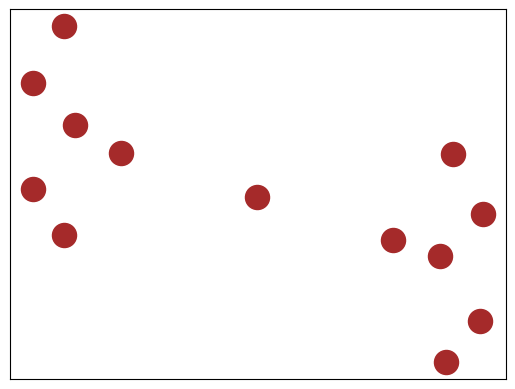

In [141]:
pos = nx.spring_layout(g_barbell, seed=123)
nx.draw_networkx_nodes(g_barbell, pos=pos, node_color="brown")

Now lets add the edges and make them blue in color. Note how this comes in as a third layer.

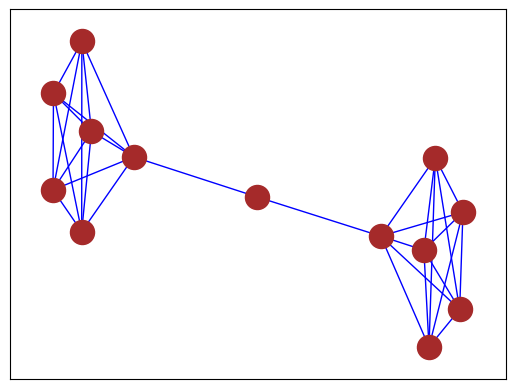

In [142]:
pos = nx.spring_layout(g_barbell, seed=123)
nx.draw_networkx_nodes(g_barbell, pos=pos, node_color="brown")
nx.draw_networkx_edges(g_barbell, pos=pos, edge_color="blue")

These changes have been purely aesthetic, but they show how the layered plotting system works. Now lets change the layout to one that forces the nodes to form a circle and provide the node labels. In this graphs nodes are just labelled as numbers.

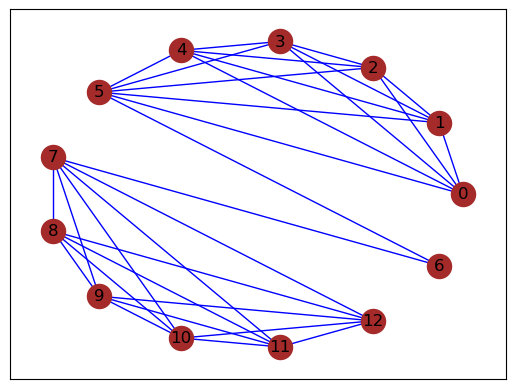

In [143]:
pos = nx.circular_layout(g_barbell)
nx.draw_networkx_nodes(g_barbell, pos=pos, node_color="brown")
nx.draw_networkx_edges(g_barbell, pos=pos, edge_color="blue")
nx.draw_networkx_labels(g_barbell, pos=pos);

We can see that for analytic purposes this was a bad decision. It is no longer transparent that the graph is two communities joined by a lonely node. However we can still to some extent see that node 6 is the one that connects the upper half, and lower half, of the network. 

Other layouts may superimpose some nodes in order to reveal something about the stucture of the network.

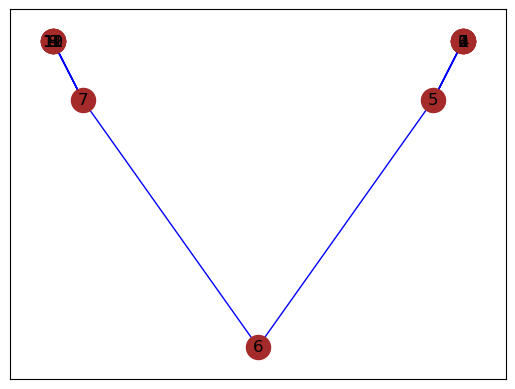

In [144]:
pos = nx.spectral_layout(g_barbell)
nx.draw_networkx_nodes(g_barbell, pos=pos, node_color="brown")
nx.draw_networkx_edges(g_barbell, pos=pos, edge_color="blue")
nx.draw_networkx_labels(g_barbell, pos=pos);

For most purposes layouts like the spring layout or kamada kawai will give reasonable representations of the network. But it is good to know that one can play around with different representations, Some may be more useful than others.

Now, because networkx builds plots in layers, it is possible to give different nodes or edges different treatment, perhaps changing their color, or dropping them out altogether.  For example, here we can node 6, the sole node of the staff part of the barbell stand out by giving it ia different color.  

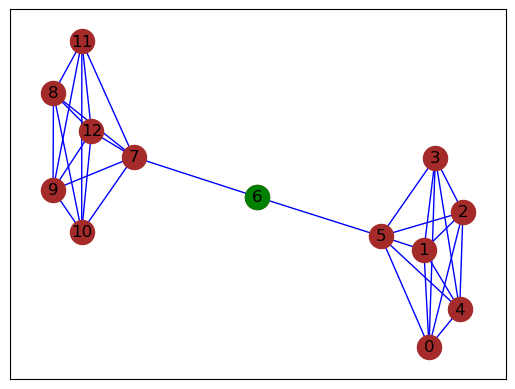

In [145]:
pos = nx.spring_layout(g_barbell, seed=123)
nx.draw_networkx_nodes(g_barbell, pos=pos, node_color="brown")
nx.draw_networkx_nodes(g_barbell, pos=pos, nodelist=[6], node_color="green")
nx.draw_networkx_edges(g_barbell, pos=pos, edge_color="blue")
nx.draw_networkx_labels(g_barbell, pos=pos);


## Taming "hairballs"

There are some strategies that can be used to tame unwieldy networks. The first and most obvious one is to decrease the node size. Another thing that may be beneficial is to introduce transparency to the nodes. This is normally called the "alpha" value in such functions. Here we will reduce the node size to a tenth of the default value (300) and introduce 50% transparency for both the nodes and the arrows. As a result, where nodes overlap, they will have a stronger shade of blue, and where arrows overlap they will be more clearly black in color. 

#### !!! are the arrows pointing in the right direction in consprot?

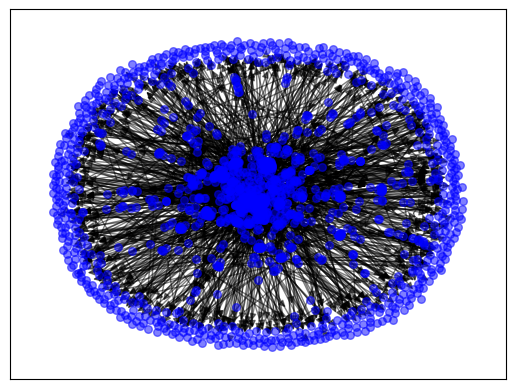

In [146]:
pos = nx.spring_layout(g_consprot)
nx.draw_networkx_nodes(g_consprot, pos=pos, node_color="blue", node_size=30, alpha=0.5)
nx.draw_networkx_edges(g_consprot, pos=pos, edge_color="black", alpha=0.5);

Another possibility is to filter the hairball network into one of more manageable size. Here the strategy is to keep only the top 40 nodes in terms of in-degree. Lets present this step-by-step. 

First we get the top40 nodes in terms of degree.

In [147]:
results = nx.in_degree_centrality(g_consprot)

Now we put these into a dataframe, to take advantage of pandas ```nlargest``` method (using Pandas is not the only way to do this, but perhaps it is the most intuitive).

In [148]:


resdf = pd.DataFrame({"score": results.values()}, index=results.keys())
resdf



,score
61995CJ0259,0.00248
61981CJ0039,0.00062
61986CJ0031,0.00062
61988CJ0331,0.00186
61995CJ0072,0.00124
...,...
62007CO0074,0.00000
62006CO0495,0.00000
62005CO0172,0.00000
62005CO0268,0.00000


We are going to need the node names as a list (we will pass these to the plotting function below) so we save them here.

In [149]:

largest40 = list(resdf.score.nlargest(40).keys())



We are also going to need the names of the edges between top40 nodes, what the list comprehension below is doing is returning only edges were both of the nodes are in the top 40.

In [150]:
largest40edges = [(x,y) for x,y in g_consprot.edges if (x in largest40 and y in largest40)]
largest40edges

[('61997CJ0087', '61989CJ0241'),
 ('62003CJ0211', '61982CJ0227'),
 ('61989CJ0241', '61978CJ0120'),
 ('61989CJ0241', '61981CJ0286'),
 ('61989CJ0241', '61984CJ0178'),
 ('61981CJ0286', '61978CJ0120'),
 ('62008CJ0040', '61998CJ0240'),
 ('62008CJ0040', '62005CJ0168'),
 ('62008CJ0040', '62008CJ0040'),
 ('62008CJ0040', '62008CJ0243'),
 ('62010CJ0618', '61998CJ0240'),
 ('62010CJ0618', '62005CJ0168'),
 ('62010CJ0618', '62008CJ0040'),
 ('62010CJ0618', '62008CJ0243'),
 ('62010CJ0618', '62010CO0076'),
 ('62011CJ0415', '62005CJ0168'),
 ('62011CJ0415', '62008CJ0040'),
 ('62011CJ0415', '62008CJ0243'),
 ('62011CJ0415', '62010CJ0472'),
 ('62011CJ0415', '62010CJ0618'),
 ('62011CJ0415', '62010CO0076'),
 ('62012CJ0470', '61998CJ0240'),
 ('62012CJ0470', '62005CJ0168'),
 ('62012CJ0470', '62008CJ0040'),
 ('62012CJ0470', '62008CJ0243'),
 ('62012CJ0470', '62010CJ0472'),
 ('62012CJ0470', '62010CO0076'),
 ('62014CJ0169', '62005CJ0168'),
 ('62014CJ0169', '62008CJ0040'),
 ('62014CJ0169', '62008CJ0317'),
 ('62014CJ

Finally, because the network will be smaller, we might get away with adding some labels. Labels must be introduced as a dictionary mapping node ids to the label names. This can be useful for create shorter, custom labels. In this case we don't want to do this, we want to use the node name as the label; but still we need a dictionary and not a list, so we are going to create a dictionary where every value is identical to its key name, which is a bit of a pointless operation, but allows us to get the data into the form that networkx wants it.

In [151]:
labelsdict = {x : x for x in largest40}
labelsdict

{'61992CJ0091': '61992CJ0091',
 '62003CJ0210': '62003CJ0210',
 '62001CJ0491': '62001CJ0491',
 '61994CJ0178': '61994CJ0178',
 '62008CJ0040': '62008CJ0040',
 '62010CJ0618': '62010CJ0618',
 '62003CJ0402': '62003CJ0402',
 '61984CJ0178': '61984CJ0178',
 '61989CJ0241': '61989CJ0241',
 '62011CJ0415': '62011CJ0415',
 '61982CJ0227': '61982CJ0227',
 '62000CO0345': '62000CO0345',
 '61997CJ0087': '61997CJ0087',
 '61978CJ0120': '61978CJ0120',
 '61998CJ0240': '61998CJ0240',
 '62013CJ0026': '62013CJ0026',
 '62011CJ0092': '62011CJ0092',
 '61999CJ0144': '61999CJ0144',
 '62004CJ0033': '62004CJ0033',
 '62005CJ0168': '62005CJ0168',
 '62008CJ0317': '62008CJ0317',
 '62007CJ0487': '62007CJ0487',
 '61981CJ0286': '61981CJ0286',
 '62012CJ0470': '62012CJ0470',
 '62008CJ0243': '62008CJ0243',
 '62003CJ0336': '62003CJ0336',
 '61981CJ0124': '61981CJ0124',
 '62014CJ0169': '62014CJ0169',
 '62008CJ0540': '62008CJ0540',
 '62007CJ0261': '62007CJ0261',
 '62002CJ0434': '62002CJ0434',
 '61999CJ0478': '61999CJ0478',
 '62003C

Here is the end result. We have also scaled the label font size to 6, and made it a little bit transparent.

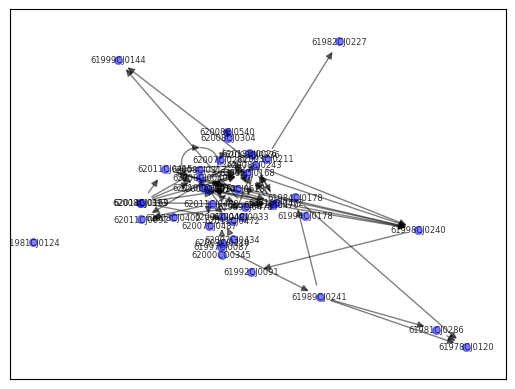

In [152]:
pos = nx.spring_layout(g_consprot)
nx.draw_networkx_nodes(g_consprot, pos=pos, nodelist= largest40, node_color="blue", node_size=30, alpha=0.5)
nx.draw_networkx_edges(g_consprot, pos=pos, edgelist=largest40edges, edge_color="black", alpha=0.5)
nx.draw_networkx_labels(g_consprot, labels=labelsdict, pos=pos, font_size=6, alpha=0.8);